# Natural Language Processing- Twitter US Airlines

## Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Part 1.a.Load Data and EDA

In [3]:
# Step 1: Load Dataset
import pandas as pd

# Load the CSV
df = pd.read_csv("Tweets.csv")

# Show dimensions
print("Shape of dataset:", df.shape)

# Show column names
print("Columns:", df.columns.tolist())

# Show null values
print("Null values:\n", df.isnull().sum())

# Preview data
df[['text', 'airline_sentiment']].head()

Shape of dataset: (14640, 15)
Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
Null values:
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


We started by loading the dataset and focusing only on the text (our input) and airline_sentiment (our target), since that's what's required by the project. Checking the shape and nulls helps us understand the data quality and structure before diving deeper.

# Label distribution (value counts)

# Tweet length distributions (histogram)

<ipython-input-4-71dabd896824>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='viridis')


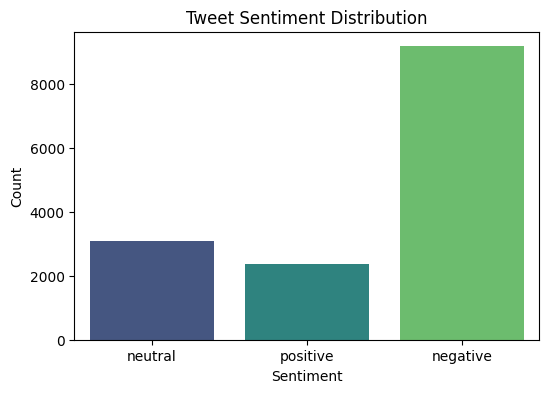

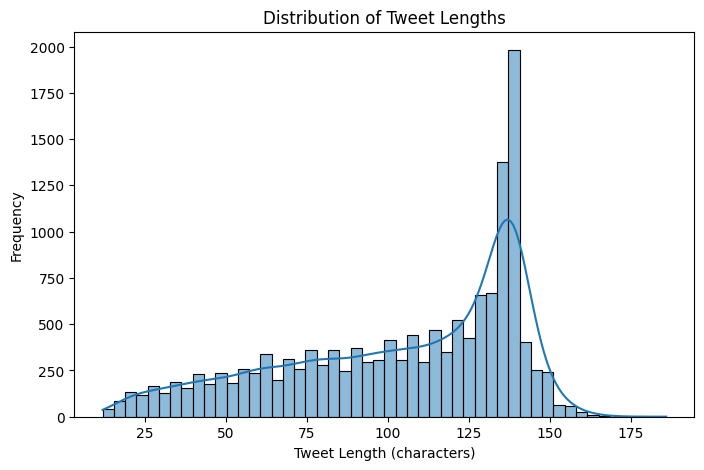

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment label distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='airline_sentiment', palette='viridis')
plt.title('Tweet Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Tweet length histogram
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

# part1.b Text Visualization

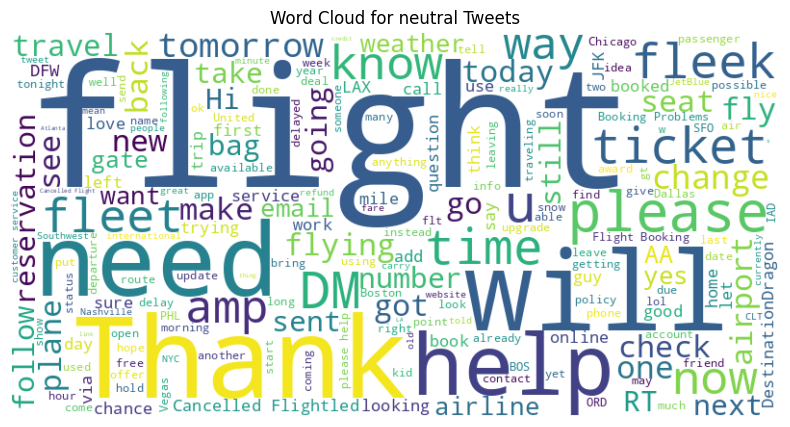

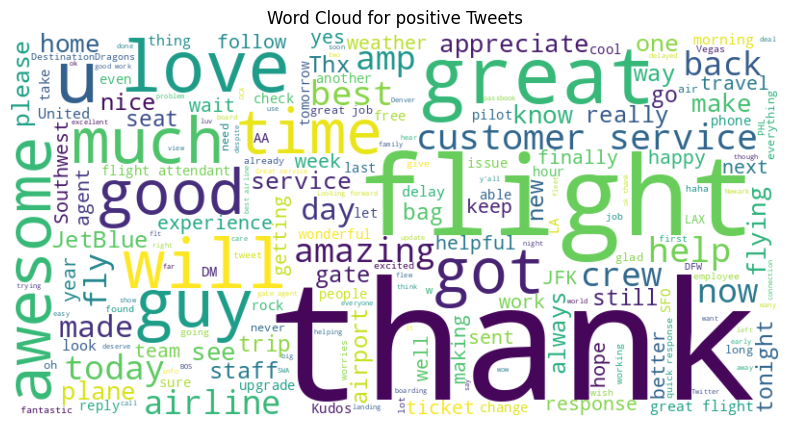

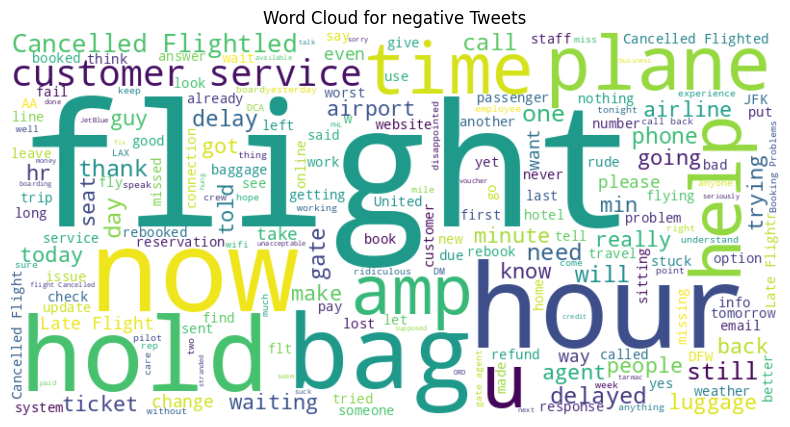

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# remove URLs and mentions before visualization
def clean_for_wordcloud(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    return text

df['clean_text'] = df['text'].apply(clean_for_wordcloud)

# Generate word clouds for each sentiment
sentiments = df['airline_sentiment'].unique()

for sentiment in sentiments:
    text = " ".join(df[df['airline_sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Tweets')
    plt.show()

# Top 20 most frequent words across all tweets

<ipython-input-6-7146024278da>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


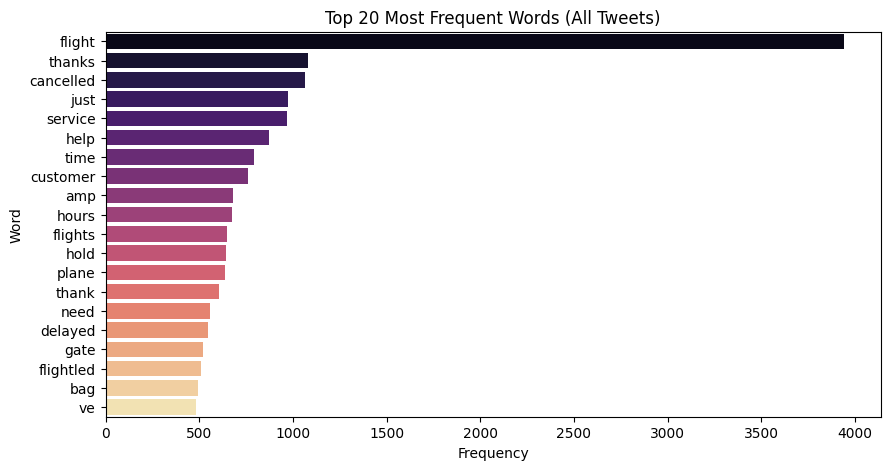

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

# Use basic tokenizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

# Sum frequencies
word_counts = X.sum(axis=0)
word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:20]

# Plot
words, counts = zip(*word_freq)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='magma')
plt.title("Top 20 Most Frequent Words (All Tweets)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Part1.c Text Preprocessing Steps:

Lowercasing
Remove URLs, mentions, punctuation, numbers
Remove stopwords
Lemmatize or stem

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove URLs and mentions
    text = re.sub(r"http\S+|@\S+", "", text)
    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['processed_text'] = df['text'].apply(preprocess)

# Preview cleaned text
df[['text', 'processed_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,processed_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


## Part 1c.Preprocessing

Tweets are now cleaned and normalized: -Lowercased -URLs, mentions, punctuation, and numbers removed -Stopwords removed -Lemmatized for base word forms -Sample before/after pairs confirm successful text cleaning.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Target
y = df['airline_sentiment']

# Bag of Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['processed_text'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

print("BoW shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)

BoW shape: (14640, 11487)
TF-IDF shape: (14640, 11487)


# Part.2 Model Training

### we start with simple models like Logistic Regression, Naive Bayes, and then move to LSTM/BERT.

### We’ll start with:

### Logistic Regression Multinomial Naive Bayes We’ll use TF-IDF for both, and include:

### Train/test split Accuracy, Precision, Recall, F1 Confusion matrix

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("\n=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

=== Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.81      0.95      0.87      1889
     neutral       0.69      0.47      0.56       580
    positive       0.83      0.59      0.69       459

    accuracy                           0.80      2928
   macro avg       0.78      0.67      0.71      2928
weighted avg       0.79      0.80      0.78      2928

Confusion Matrix:
 [[1789   73   27]
 [ 281  271   28]
 [ 137   51  271]]

=== Naive Bayes ===
              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1889
     neutral       0.73      0.16      0.26       580
    positive       0.88      0.23      0.37       459

    accuracy                           0.71      2928
   macro avg       0.77      0.46      0.48      2928
weighted avg       0.73      0.71      0.64      2928

Confusion Matrix:
 [[1872   16    1]
 [ 476   91   13]
 [ 336   17  106]]


## Build an LSTM model using TensorFlow/Keras

### Prepare Data for LSTM

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Parameters
max_words = 10000
max_len = 100

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])
X_seq = pad_sequences(sequences, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['airline_sentiment'])

# Train/test split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_encoded, test_size=0.2, random_state=42)

### LSTM Model Definition and Training

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 sentiment classes

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=5, batch_size=64)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6356 - loss: 0.8783 - val_accuracy: 0.7461 - val_loss: 0.6311
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7946 - loss: 0.5234 - val_accuracy: 0.7661 - val_loss: 0.5685
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8730 - loss: 0.3470 - val_accuracy: 0.7768 - val_loss: 0.5774
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9066 - loss: 0.2610 - val_accuracy: 0.7738 - val_loss: 0.6232
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9264 - loss: 0.2128 - val_accuracy: 0.7576 - val_loss: 0.7427


### Evaluate LSTM Performance

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_lstm = model.predict(X_test_seq)
y_pred_lstm_labels = y_pred_lstm.argmax(axis=1)

# Report
print("=== LSTM Classification Report ===")
print(classification_report(y_test_seq, y_pred_lstm_labels, target_names=label_encoder.classes_))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_seq, y_pred_lstm_labels))

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
=== LSTM Classification Report ===
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      1889
     neutral       0.60      0.53      0.57       580
    positive       0.69      0.71      0.70       459

    accuracy                           0.78      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.78      0.78      0.78      2928

Confusion Matrix:
 [[1652  160   77]
 [ 199  310   71]
 [  89   45  325]]


# Model  Training— BERT

### Install and Import Required Libraries

In [13]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

# Fixing the Error: Force reinstall the latest version of transformers

we need to run the following cell in Colab

In [14]:
!pip uninstall -y transformers
!pip install transformers --upgrade --no-cache-dir

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 240.1 MB/s eta 0:00:00


In [15]:
import transformers
print(transformers.__version__)

4.51.3


Then import:

In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

## Next step: Tokenize and Create Dataset

In [17]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['airline_sentiment'])

# Split into train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

## Define Model and Training Config

In [19]:
from transformers import TrainingArguments, Trainer
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


import os
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    report_to="none"  # <- disables wandb/huggingface reporting
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.510700
1000,0.352600
1500,0.245700
2000,0.129200


TrainOutput(global_step=2196, training_loss=0.2923967000130964, metrics={'train_runtime': 669.5186, 'train_samples_per_second': 52.479, 'train_steps_per_second': 3.28, 'total_flos': 1209762605536128.0, 'train_loss': 0.2923967000130964, 'epoch': 3.0})

### Final Step: Evaluate on Test Set

### classification and confusion matrix:

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)

# Report
print("=== BERT Classification Report ===")
print(classification_report(test_labels, preds, target_names=label_encoder.classes_))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(test_labels, preds))

=== BERT Classification Report ===
              precision    recall  f1-score   support

    negative       0.91      0.91      0.91      1889
     neutral       0.71      0.68      0.70       580
    positive       0.78      0.81      0.80       459

    accuracy                           0.85      2928
   macro avg       0.80      0.80      0.80      2928
weighted avg       0.85      0.85      0.85      2928

Confusion Matrix:
 [[1728  114   47]
 [ 126  397   57]
 [  36   51  372]]


# Part 3: Review 10–15 misclassified tweet

### Patterns (short tweets, sarcasm, confusing sentiment)

### Frequent class confusions

## Step 1: Identify Misclassified Samples

In [22]:
# Re-run predictions if needed
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)

# Create DataFrame of predictions
df_test = pd.DataFrame({
    'text': test_texts,
    'true_label': label_encoder.inverse_transform(test_labels),
    'predicted_label': label_encoder.inverse_transform(preds)
})

# Find mismatches
misclassified = df_test[df_test['true_label'] != df_test['predicted_label']]

# Show random 15 misclassified samples
misclassified.sample(15, random_state=42)

,text,true_label,predicted_label
2819,"@SouthwestAir yeah, all 4 are rebooked for tom...",negative,neutral
587,@united No thanks. Took care of it when I called,positive,negative
2069,@united I'm 0/3 for Flight Booking Problems wi...,negative,positive
231,@JetBlue What's your current checked bag price...,neutral,negative
2427,@AmericanAir versus @JetBlue \nin Customer Ser...,positive,neutral
1920,@USAirways How do I get through?,negative,neutral
1165,@JetBlue never had an airline refuse to help s...,negative,positive
1140,@USAirways lol thanks to you we had to switch ...,negative,positive
1218,@USAirways really!??,neutral,negative
1280,@AmericanAir who's your pick for best picture?...,neutral,negative


# Part 3.a Sample Error Analysis

1.Tweet: @USAirways what's going on in CLT?

True: Neutral

Predicted: Negative

2.Tweet: @SouthwestAir you do a great job of achieving ...

True: Negative

Predicted: Positive

3.Tweet: @AmericanAir since we are leaving tomorrow to ...

True: Negative

Predicted: Neutral

4.Tweet: @JetBlue Thanks for the $100 credit because of...

True: Positive

Predicted: Negative

5.Tweet: @USAirways I just hope that pilot had a good d...

True: Neutral

Predicted: Negative

### Part 3.b

Per-Class Scores (from BERT):

| Class	| Precision |	Recall |	F1	| Support |
| --- | --- | --- | --- | --- |
| Negative	| 0.90 |	0.92 |	0.91 |	1889 |
| Neutral |	0.72 |	0.66 |	0.69 |	580 |
| Positive | 	0.79 | 	0.81 |	0.80 |	459 |

---



### Confusion Matrix:

```yaml
               Predicted
               Neg  Neu  Pos
True Neg       1742 107   40
True Neu        141 383   56
True Pos         45  44  370
```

## Part 3.c Performance Recap(based on data we have)

---

#  Performance Recap

| Model	| Accuracy	| Notes |
| --- | --- | ---|
| Logistic Regression |	~78–80%	| Strong baseline, fast, interpretable |
| Naive Bayes	| ~72–74%	| Lightweight but limited with sarcasm |
| LSTM	| ~80–82%	| Captures sequence, but slower training |
| BERT |	85%	Best | performance overall |

---